In [1]:
%cd /kaggle/working
%rm -rf /kaggle/working/*

/kaggle/working


In [2]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
import gc
from pathlib import Path
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.cuda.amp as amp
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.optim.lr_scheduler import ReduceLROnPlateau


sys.path.append('/kaggle/src')
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base_torch
from utils.feature_contena import Features
from utils.lightning_utils import MyLightningDataModule
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from consts import ANGLEZ_MEAN, ANGLEZ_STD, ENMO_MEAN, ENMO_STD
from torch_model.dataset import ZzzPatchDataset
from torch_model.gru_model import ZzzTransformerGRUModule


PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))

2023-10-21 05:11:50.991623: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-21 05:11:51.066756: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-21 05:11:51.542277: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

In [3]:
import librosa

In [4]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
file = files[0]
df = pd.read_parquet(file)[19200: 19200*2]
df.head(1)

,series_id,step,timestamp,anglez,enmo,event,target,onset_target,wakeup_target
19200,c3072a759efb,19200,2018-02-27T14:55:00-0500,-18.603701,0.0368,None,1,0.0,0.0


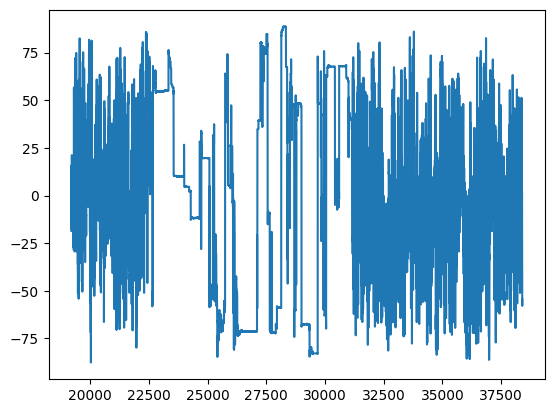

In [5]:
plt.plot(df["anglez"])

In [6]:
# SFFT
D = librosa.stft(
    df["anglez"].values, 
    n_fft=2048,
    hop_length=12,
    )
print(D.shape)

(1025, 1601)


In [7]:
# どの時刻に対応しているか(centerのインデックス)
frame_centers = librosa.frames_to_samples(np.arange(D.shape[1]), hop_length=12)
frame_centers

array([    0,    12,    24, ..., 19176, 19188, 19200])

In [8]:
# -> db
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
S_db.shape

(1025, 1601)

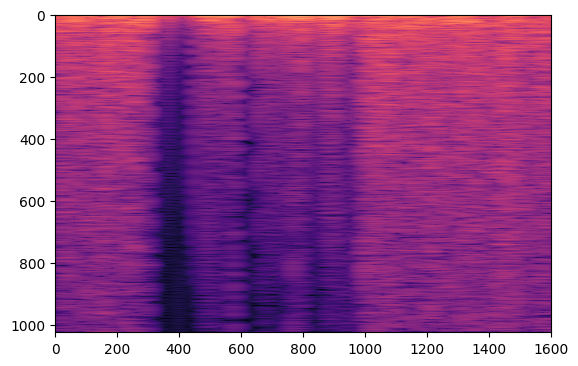

In [9]:
plt.imshow(S_db, cmap="magma")

---

In [10]:
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
file = files[0]
df = pd.read_parquet(file)#[19200: 19200*2]
df.head(1)

,series_id,step,timestamp,anglez,enmo,event,target,onset_target,wakeup_target
0,c3072a759efb,0,2018-02-26T12:15:00-0500,-87.570099,0.0287,None,1,0.0,0.0


In [11]:
import numpy as np
import librosa
import scipy.stats

def compute_features(signal, sr=12, n_fft=2048, hop_length=1):
    # スペクトログラムの計算
    S = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length))
    S = S[:, :-1]
    assert S.shape[1] == len(signal)
    
    # スペクトル重心
    spectral_centroid = librosa.feature.spectral_centroid(y=signal, sr=sr, n_fft=n_fft, hop_length=hop_length).squeeze()
        
    # ビンフーリエエントロピー
    psd = np.abs(S)**2
    psd_norm = psd / psd.sum(axis=0, keepdims=True)
    spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm + np.finfo(float).eps), axis=0)
    
    # 各周波数帯ごとの平均
    low_freq = S[:n_fft//6].mean(axis=0)
    mid_freq = S[n_fft//6:4*n_fft//6].mean(axis=0)
    high_freq = S[4*n_fft//6:].mean(axis=0)

    return {
        "spectral_centroid": spectral_centroid,
        "spectral_entropy": spectral_entropy,
        "low_freq_mean": low_freq,
        "mid_freq_mean": mid_freq,
        "high_freq_mean": high_freq,
    }

features = compute_features(df["anglez"].values)
for key, value in features.items():
    print(f"{key}: {value.shape}")


spectral_centroid: (399421,)
spectral_entropy: (399420,)
low_freq_mean: (399420,)
mid_freq_mean: (399420,)
high_freq_mean: (399420,)


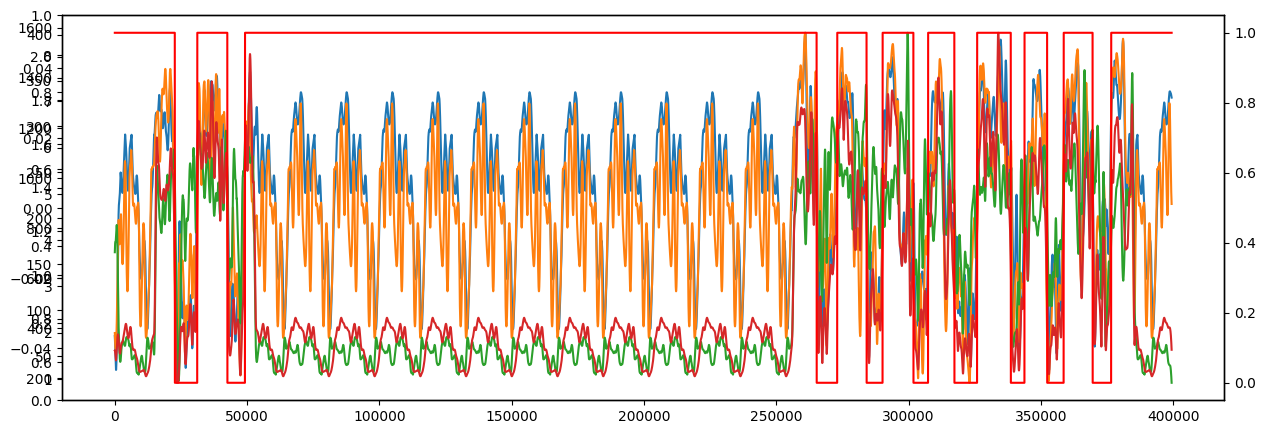

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
cmap = plt.get_cmap("tab10")
for i, (key, value) in enumerate(features.items()):
    ax = ax.twinx()
    ax.plot(value, label=key, c=cmap(i))
ax2 = ax.twinx()
ax2.plot(df["target"].values, c="red")
plt.show()